In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import opendatasets as od
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Loading the dataset

We are using the popular Cats and Dogs Dataset, this dataset has 2 classes.

After loading the dataset we will set the hyperparameters batch size and epoch numbers and will set the image size to 100x100

In [2]:
data_dir = r'D:\cats_vs_dogs'
img_size = (100, 100)
batch_size = 8
num_of_classes = 2
num_of_epochs = 10

# Initializing data augmentation and preprocessing

initilializing augmentation using data generator.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(rescale = 1.0/255, rotation_range = 20, width_shift_range = 0.2, height_shift_range = 0.2,
                            horizontal_flip = True)

# Loading Images and their respective labels

In [5]:
images = []
labels = []

# Iterate through class directories
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_label = class_name  # Use class name as label
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
            labels.append(class_label)

C:\Users\anasj\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


# Converting to Numpy Arrays

In [6]:
images = np.array(images)
labels = np.array(labels)

In [7]:
len(labels) #total images in dataset

24998

In [8]:
from sklearn.model_selection import train_test_split

# Splitting Dataset into train, test and validation sets

In [9]:
# Splitting Dataset into train, test and validation sets
# First split into train and temporary sets
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
# Second split: splitting temporary set into validation and test sets
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_numerical = label_encoder.fit_transform(y_train)
y_valid_numerical = label_encoder.transform(y_valid)

# Convert numerical labels to one-hot encoded format
y_train_encoded = to_categorical(y_train_numerical, num_classes=num_of_classes)
y_valid_encoded = to_categorical(y_valid_numerical, num_classes=num_of_classes)

# Generate batches and implement data augmentation initialized earlier
train_gen = datagen.flow(x_train, y_train_encoded, batch_size=batch_size)
valid_gen = datagen.flow(x_valid, y_valid_encoded, batch_size=batch_size)



# Loading a Pre-trained model

Loading MobileNetV2 model
By using the initial layers of the pre-trained model we are implementing "TRANSFER LEARNING" as we are rejecting the top layers
which include the fully connected layers of MobileNetV2 trained on ImageNet dataset. In simpler terms we are taking only the architecture and the weights of the said model.

In [10]:
# Load a pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(100, 100, 3), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_of_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model

In [11]:
# Train the model
history = model.fit(
    train_gen,
    epochs=num_of_epochs,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=valid_gen,
    validation_steps=len(x_valid) // batch_size
)

Epoch 1/10
2187/2187 [==============================] - 84s 38ms/step - loss: 0.3014 - accuracy: 0.8735 - val_loss: 0.2649 - val_accuracy: 0.8878
Epoch 2/10
2187/2187 [==============================] - 82s 37ms/step - loss: 0.2420 - accuracy: 0.8947 - val_loss: 0.2247 - val_accuracy: 0.8942
Epoch 3/10
2187/2187 [==============================] - 84s 38ms/step - loss: 0.2357 - accuracy: 0.8993 - val_loss: 0.2487 - val_accuracy: 0.8876
Epoch 4/10
2187/2187 [==============================] - 86s 39ms/step - loss: 0.2295 - accuracy: 0.9014 - val_loss: 0.2226 - val_accuracy: 0.9076
Epoch 5/10
2187/2187 [==============================] - 88s 40ms/step - loss: 0.2254 - accuracy: 0.9009 - val_loss: 0.2357 - val_accuracy: 0.9062
Epoch 6/10
2187/2187 [==============================] - 85s 39ms/step - loss: 0.2128 - accuracy: 0.9091 - val_loss: 0.2305 - val_accuracy: 0.8985
Epoch 7/10
2187/2187 [==============================] - 87s 40ms/step - loss: 0.2122 - accuracy: 0.9087 - val_loss: 0.2185 -

# Plotting training and validation loss

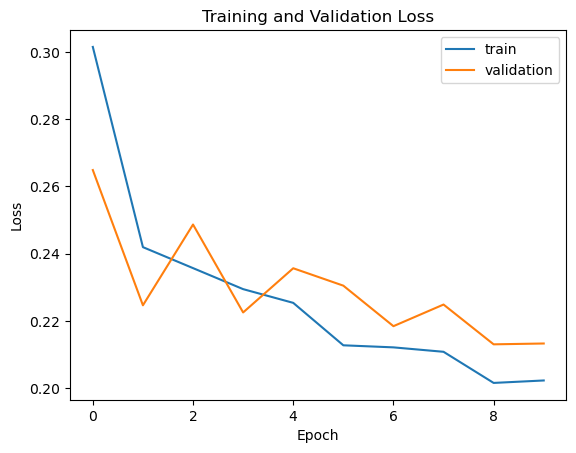

In [12]:
# Plot Training and Validation Loss Curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Ensures consistent order for predictions
)

Found 24998 images belonging to 2 classes.


In [14]:
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

2995/3125 [===========================>..] - ETA: 5s

C:\Users\anasj\anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


3125/3125 [==============================] - 125s 40ms/step


# Generating Classification report

In [15]:
from sklearn.metrics import classification_report

# Print classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         cat       0.91      0.93      0.92     12499
         dog       0.93      0.90      0.92     12499

    accuracy                           0.92     24998
   macro avg       0.92      0.92      0.92     24998
weighted avg       0.92      0.92      0.92     24998



# Saving the model

In [16]:
model.save("cats_vs_dogs_model.h5")

C:\Users\anasj\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
